# Imports

* **NumPy**: To structure and manipulate data efficiently
* **MatPlotLib**: To visualize the process of manipulating the data
* **Panel**: To import a CSV file from the computer
* **io**: Allows imported files to be read from memory and used as if they were on the disk, making importing data possible without the need for creating a temperary file

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
import io

# Defining CSV File Upload Widget Class
The CSVUploadWidget class facilitates CSV file uploads and processing within a Jupyter Notebook using Panel. It includes a file input widget for selecting CSV files and then uses NumPy to parse the uploaded data into a structured array (self.data). It has functions to return the stored data ('self.data()') and to return a Panel layout object to ease in displaying the widget.

In [ ]:
class CSVUploadWidget:
    """This object creates the File Upload Widget
    and stores the data in a NumPy structured array"""

    # Initialize widget and data variables
    def __init__(self):
        
        self.file_input = pn.widgets.FileInput(accept='csv')
        
        self.data = None # will later be a structured array

        # attatch file to callback function
        self.file_input.param.watch(self.upload_callback, 'value')

        self.layout = pn.Column(
            " ### Upload CSV File",
            self.file_input
            )
                    

    def upload_callback(self, event):
        
        file_data = self.file_input.value # path to file from widget
        
        if file_data is not None:

            file_like = io.BytesIO(file_data) # coverts file from memory to an object that's usable by np.genfromtxt

            self.data = np.genfromtxt(file_like, delimiter=",", names=None, skip_header=1, dtype=[('hours', np.int16), ('temp', np.float32), ('heating_rate', np.float32)], encoding='utf-8')
            

    def get_data(self):
        return self.data

    def show(self):
        return self.layout
        

# Upload Data
Creating a CSVUploadWidget object, we can use it display the widget with the 'self.show()' function. The object will then hold the data from the selected file in a NumPy Structured Array which can  be accesed anytime with the 'self.get_data()' function.

In [3]:
pn.extension() # enables displaying panel widgets on Jupyter Notebook

csv_widget = CSVUploadWidget()
csv_widget.show().servable()

Column
    [0] Markdown(str)
    [1] FileInput(accept='csv')

# COP inputs
inputs COP data one point at a time, this may be adjusted to make user input easier

In [4]:
data_type = [('temp', float), ('COP', float)]

COP_inputs = np.array([], dtype=data_type) # creating numpy array with temp and COP column 

input_value = input('''
Input a Temperature Value and a COP Value in format: Temp, COP
Enter 'done' when finished
''')

while (COP_inputs.size < 4) and (input_value == 'done'): # ensure at least 2 rows are inputed
    
    print('Please insert at least two points')
    input_value = input('''Input a Temperature Value and a COP Value in format: Temp, COP
                           Enter 'done' when finished
                           ''')
    
while input_value != 'done': 
    
    input_values = [float(i.strip()) for i in input_value.split(',')] # set up input as a tuple
    new_row = np.array([(input_values[0], input_values[1])], dtype=data_type)
                        
    COP_inputs = np.append(COP_inputs, new_row) # add input to array

    print(COP_inputs)
    
    input_value = input('''
    Input a Temperature Value and a COP Value in format: Temp, COP
    Enter 'done' when finished
    ''')
    


Input a Temperature Value and a COP Value in format: Temp, COP
Enter 'done' when finished
 -25,2


[(-25., 2.)]



    Input a Temperature Value and a COP Value in format: Temp, COP
    Enter 'done' when finished
     35,4.3


[(-25., 2. ) ( 35., 4.3)]



    Input a Temperature Value and a COP Value in format: Temp, COP
    Enter 'done' when finished
     done


# Define HPRIinfo Class
This class takes the data from the CSV widget and the COP input and uses it to calculate several constants

In [67]:
class HPRIinfo:
    """"""

    # initialize variables
    def __init__(self, dataIN, COP_dataIN):
        
        self.data = dataIN
        self.COP_data = COP_dataIN
        
        self.COPvsTemp_line = None
        self.HeatRatevsTemp_line = None

        self.balence_point = None

        self.heating_loads = None

        self.hpri = None

        self.calculate_constants() # calculates constants used to find HPRI aswell as HPRI
    
    def calculate_constants(self):

        if self.data['heating_rate'][50] > 100:
            self.W_to_kW()

        self.find_COPvsTemp_line()

        self.find_HeatRatevsTemp_line()

        self.calc_balence_point()

        self.calc_heating_loads()

        self.calc_hpri()

    def W_to_kW(self): # ensures data is in kW

        print('Converting heating rates from Watts to Kilawatts...')
        self.data['heating_rate'] /= 1000 # Convert all W values to kW

    def find_COPvsTemp_line(self): # finds COP vs Temp line using np.polyfit

        x_values = self.COP_data['temp']
        y_values = self.COP_data['COP']

        m, b = np.polyfit(x_values, y_values, 1) # created linear line of best fit, may adjust for later to allow non-linear COP vs temp lines

        self.COPvsTemp_line = (m, b)

    def find_HeatRatevsTemp_line(self): # find heat rate vs temp line using np.polyfit
        
        x_values = self.data['temp']
        y_values = self.data['heating_rate']

        m, b = np.polyfit(x_values, y_values, 1) # creates linear line of best fit

        self.HeatRatevsTemp_line = (m, b)

    def calc_balence_point(self): # finds the temperature where backup load is used by intersecting COP and heat rate lines

        m1, b1 = self.COPvsTemp_line
        m2, b2 = self.HeatRatevsTemp_line

        x = (b2 - b1) / (m1 - m2) # algebra to find x value, may need to be adjusted if one or more lines is non-linear
        y = m1 * x + b1

        self.balence_point = (x, y)


    def calc_y_at_x(self, mbpair, x): # used to find COP and total heat rate at a given temp
        
        m, b = mbpair

        y = m * x + b

        return y

    def calc_heating_loads(self):

        temperatures = self.data['temp']
        hours = self.data['hours']
        
        num_temps = len(temperatures)
        
        balence_point_temp = self.balence_point[0]

        data_type = [('hours', np.int32),
                     ('temp', np.float32),
                     ('load_from_electricity', np.float32),
                     ('load_from_heatpump', np.float32),
                     ('load_from_backup', np.float32)]

        heat_loads = np.zeros(num_temps, dtype=data_type) # sets up array which makes data manipulation and graphing easier later on
    
        for index, temp in np.ndenumerate(temperatures): # calulates loads for every temperature
            current_COP = self.calc_y_at_x(self.COPvsTemp_line, temp)
            current_total_hr = self.calc_y_at_x(self.HeatRatevsTemp_line, temp)

            if current_total_hr < 0: # ensures no negative laods are calculated
                heat_loads[index] = (hours[index], temp, 0, 0, 0)
    
            elif temp < balence_point_temp: # calculates loads if backup power is being used
                load_from_electricity = 1
                load_from_heatpump = current_COP - 1
                load_from_backup = current_total_hr - load_from_heatpump - load_from_electricity

                heat_loads[index] = (hours[index], temp, load_from_electricity, load_from_heatpump, load_from_backup) 
    
            else: # calculates loads if no backup power is used
                load_from_backup = 0
                load_from_electricity = current_total_hr / current_COP
                load_from_heatpump = current_total_hr - load_from_electricity

                heat_loads[index] = (hours[index], temp, load_from_electricity, load_from_heatpump, load_from_backup)

        self.heating_loads = heat_loads

    def calc_hpri(self): # uses loads to calculate HPRI
        
        hpri = np.sum(self.heating_loads['load_from_heatpump']) / (np.sum(self.heating_loads['load_from_electricity']) +
                                                                   np.sum(self.heating_loads['load_from_heatpump']) +
                                                                   np.sum(self.heating_loads['load_from_backup']))
        self.hpri = hpri

    def get_hpri(self):
        
        print(f'HPRI: {self.hpri}')

        return self.hpri

    def get_heating_loads(self, lower_bound=0, upper_bound=8760): # returns heating loads as numpy array
    
        data = self.heating_loads
        
        headers = data.dtype.names
    
        col_widths = {header: max(len(header), max(len(f"{item[header]}") for item in data)) for header in headers}
        
        separator = '+-' + '-+-'.join('-' * col_widths[header] for header in headers) + '-+'
        
        header_row = '| ' + ' | '.join(f"{header:{col_widths[header]}}" for header in headers) + ' |'
        
        print(separator)
        print(header_row)
        print(separator)
        
        for row in data[lower_bound:upper_bound]:
            row_str = '| ' + ' | '.join(f"{row[header]:{col_widths[header]}}" for header in headers) + ' |'
            print(row_str)
        
        print(separator)
        
        return self.heating_loads

    def show_COPvsTemp_graph(self, show_points=True): # show_points parameter allows for functions use in later graphs

        x = np.array([min(self.COP_data['temp']) - 5, max(self.COP_data['temp']) + 5]) # setting up the line's bounds

        m, b = self.COPvsTemp_line
        
        plt.plot(x, m * x + b, '--')

        if show_points:
            
            plt.scatter(self.COP_data['temp'], self.COP_data['COP'])

            plt.xlabel('Temperature')
            plt.ylabel('COP')
            plt.title('COP vs Temperature (C)')
            
            plt.show()
        

    def show_HeatRatevsTemp_graph(self, show_points=True):
        
        x = np.array([min(self.data['temp']), max(self.data['temp'])]) # setting up the line's bounds

        m, b = self.HeatRatevsTemp_line
        
        plt.plot(x, m * x + b, '--y') 

        if show_points:
            
            plt.scatter(self.data['temp'], self.data['heating_rate'], s=1, alpha=.2)
            
            plt.xlabel('Temperature')
            plt.ylabel('Heat Rate')
            plt.title('Heat Rate (kW) vs Temperature (C)')
            
            plt.show()

    def show_balence_point_graph(self):

        balence_point_x, balence_point_y = self.balence_point
        
        self.show_COPvsTemp_graph(show_points=False)
        self.show_HeatRatevsTemp_graph(show_points=False)
        
        plt.plot(balence_point_x, balence_point_y, 'o', markersize=10, label='Balence Point', c='green')

        plt.text(balence_point_x + 3, balence_point_y - .2, f"Balence Point: ({balence_point_x:.4f}, {balence_point_y:.4f})")

        plt.xlabel('Temperature')
        plt.ylabel('COP and Heat Rate(kW)')
        plt.title('Balence Point')

        plt.show()

    def show_HeatingLoadsvsTime_graph(self):
        
        data = self.heating_loads
        
        hours = data['hours']
        load_from_electricity = data['load_from_electricity']
        load_from_heatpump = data['load_from_heatpump']
        load_from_backup = data['load_from_backup']
        
        # Create the stackplot
        plt.stackplot(hours, load_from_electricity, load_from_heatpump, load_from_backup,
                      labels=['Electricity', 'Heatpump', 'Backup'], colors=['b', 'g', 'r'])
        
        plt.xlabel('Hours')
        plt.ylabel('Load')
        plt.title('Stacked Load Over Hours')
        plt.legend(loc='upper left')
        
        plt.show()
            

    def show_HeatingLoadsvsTemp_graph(self):
        data = self.heating_loads

        data = np.sort(data, order=['temp'])
        
        temp = data['temp']
        load_from_electricity = data['load_from_electricity']
        load_from_heatpump = data['load_from_heatpump']
        load_from_backup = data['load_from_backup']
        
        # Create the stackplot
        plt.stackplot(temp, load_from_electricity, load_from_heatpump, load_from_backup,
                      labels=['Electricity', 'Heatpump', 'Backup'], colors=['b', 'g', 'r'])
        
        plt.xlabel('Temperature')
        plt.ylabel('Load')
        plt.title('Stacked Load Over Temp')
        plt.legend(loc='upper left')
        
        plt.show()

    def show_all_graphs(self):
        
        self.show_COPvsTemp_graph()
        self.show_HeatRatevsTemp_graph()
        self.show_balence_point_graph()
        self.show_HeatingLoadsvsTime_graph()
        self.show_HeatingLoadsvsTemp_graph()
        

# Creating HPRIinfo object

In [68]:
input_data = csv_widget.get_data()
COP_data = COP_inputs

example_1 = HPRIinfo(dataIN=input_data, COP_dataIN=COP_data)

# Showing Graphs
Using the HPRIinfo.show_all_graphs() function, all 5 graphs will be displayed to show the process of calculating HPRI

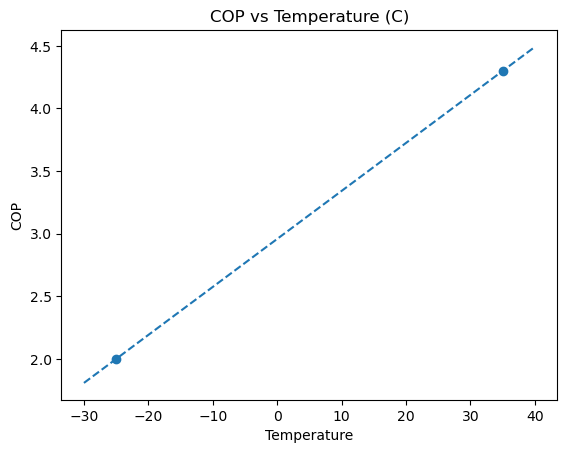

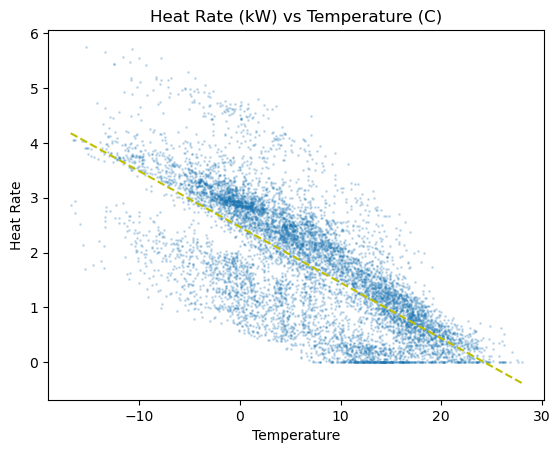

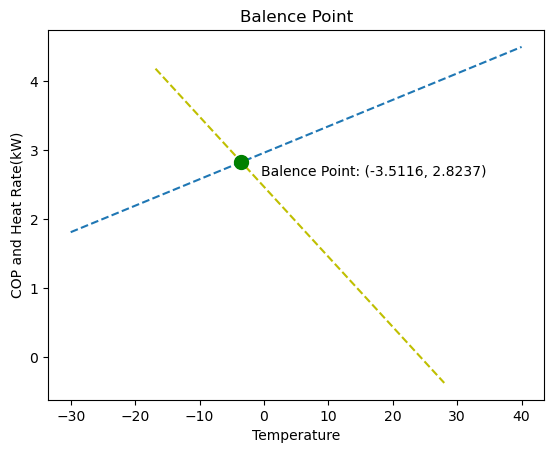

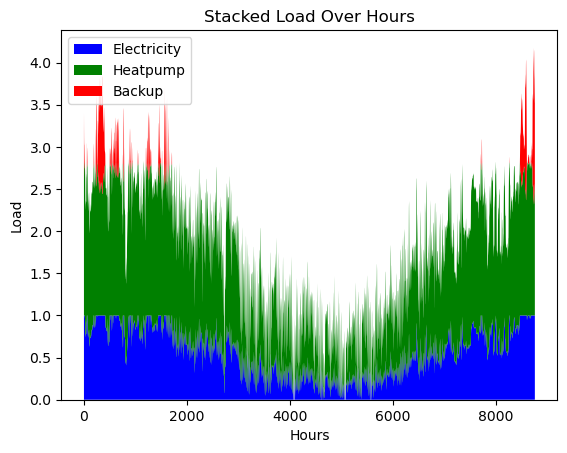

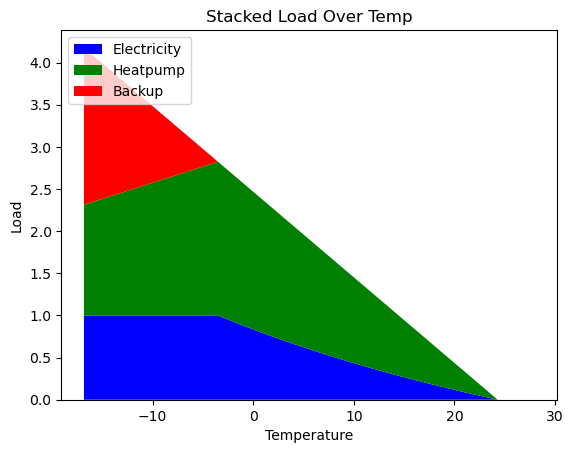

In [40]:
test2.show_all_graphs()

# Showing HPRI
Display the building's HPRI using the HPRIinfo.get_hpri() function

In [73]:
example_1.get_hpri()

HPRI: 0.6525919437408447


0.65259194

# Showing Heat Rates
Show the heat rates and temperatures for every hour, with lower bound and upper bound

In [72]:
example_1.get_heating_loads(100, 500)

+-------+-----------------------+-----------------------+-----------------------+-----------------------+
| hours | temp                  | load_from_electricity | load_from_heatpump    | load_from_backup      |
+-------+-----------------------+-----------------------+-----------------------+-----------------------+
|   101 |   0.23333300650119781 |     0.823465883731842 |    1.6199860572814941 |                   0.0 |
|   102 |    0.6916670203208923 |    0.8030263185501099 |    1.5938845872879028 |                   0.0 |
|   103 |      1.13332998752594 |    0.7835565805435181 |    1.5685060024261475 |                   0.0 |
|   104 |      1.88332998752594 |    0.7509928345680237 |    1.5249117612838745 |                   0.0 |
|   105 |    2.8833301067352295 |    0.7085236310958862 |    1.4658368825912476 |                   0.0 |
|   106 |    3.8833301067352295 |    0.6671022772789001 |    1.4057141542434692 |                   0.0 |
|   107 |     4.416669845581055 |    0.6454258

array([(   1,  -6.93333, 1., 1.6925557, 0.47862822),
       (   2,  -9.31667, 1., 1.6011943, 0.8120036 ),
       (   3,  -7.46667, 1., 1.672111 , 0.5532304 ), ...,
       (8758, -16.3667 , 1., 1.3309432, 1.7981431 ),
       (8759, -15.5    , 1., 1.3641666, 1.6769116 ),
       (8760, -13.8333 , 1., 1.4280568, 1.4437779 )],
      dtype=[('hours', '<i4'), ('temp', '<f4'), ('load_from_electricity', '<f4'), ('load_from_heatpump', '<f4'), ('load_from_backup', '<f4')])